In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams["font.size"] = 14

import utils
import importlib
importlib.reload(utils)

import os
import sys
import subprocess

In [2]:
train, test, info, index = utils.ReadData("debug3")

In [3]:
val = test.values
train_for_val = train.values

In [4]:
log_train_for_val = np.log1p(np.nan_to_num(train_for_val))

In [5]:
# restore indices of weekly seasonal, many zeros
weekly_indices = np.load("../data/google_wtts/weekly_index_for_score.npy")
weekly_indices = np.argwhere(np.isin(index.values.reshape(-1), weekly_indices))

zeros_indices = np.load("../data/google_wtts/zeros_index_for_score.npy")
zeros_indices = np.argwhere(np.isin(index.values.reshape(-1), zeros_indices))

In [6]:
from pykalman import KalmanFilter

In [7]:
def plot_KF(row_train, row_val, preds, title, lags=100):
    plt.plot(np.concatenate((row_train[-lags:], row_val)), label='validation')
    plt.vlines(lags, row_val.min(), row_val.max(), linestyles='--')
    plt.plot(row_train[-lags:], label='train')
    plt.plot(preds[-(lags + 60):], label='prediction')
    plt.xlabel('days')
    plt.ylabel('log')
    plt.legend()
    plt.title(title)
    plt.show()
    


In [8]:
def print_parameters(kf_model, need_params=None):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if need_params is None:
        need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    for param in need_params: 
        print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))

# Model

In [132]:
def KF_for_row(i, em_vars=[
                  'transition_matrices', 
                  'observation_matrices',
                  'transition_covariance', 
                  'observation_covariance',
#                   'observation_offsets'
    ], only_forecast=True, n_dim_state=1):
    
    def predicting(days=60):
        preds = []
        last_z_mean = smoothed_state_means[-1]
        for i in range(60):
            new_z_mean = kf.transition_matrices.dot(last_z_mean)
            preds.append(kf.observation_matrices.dot(new_z_mean))
            last_z_mean = new_z_mean

        preds = np.array(preds).ravel()
        return preds
    
#     n_dim_state = 1
    kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=1)

    # Use EM algorithm to estimate the parameters
    kf.em(log_train_for_val[i], n_iter=20, em_vars=em_vars)
    
    # Smoothing
    smoothed_state_means, _ = kf.smooth(log_train_for_val[i])
    # Sampling
#     sampled_states, sampled_observations = kf.sample(60, initial_state=smoothed_state_means[-1], random_state=np.random.RandomState(0))
    preds = predicting()
    print(i, "finished")
    
    if only_forecast:
        return preds
    else:
        smoothed_observations = np.sum(np.multiply(smoothed_state_means, kf.observation_matrices.ravel()), axis=1)
        return np.array(np.concatenate((smoothed_observations.ravel(), preds)))

In [128]:
i = 41
preds = KF_for_row(i, only_forecast=False, n_dim_state=2)

41 finished


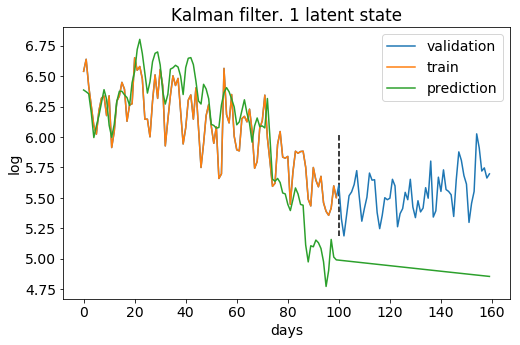

In [133]:
row_train = log_train_for_val[i]
plot_KF(row_train, np.log1p(np.array(test.iloc[i])),
        preds, 'Kalman filter. 1 latent state')

46 finished


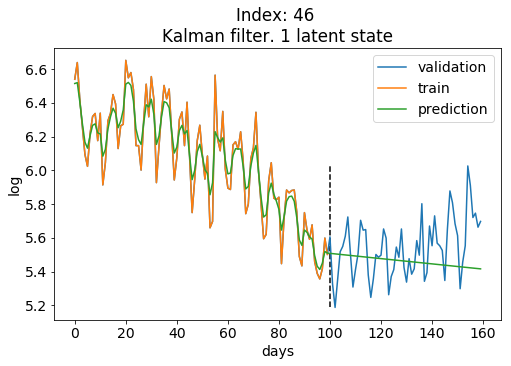

49 finished


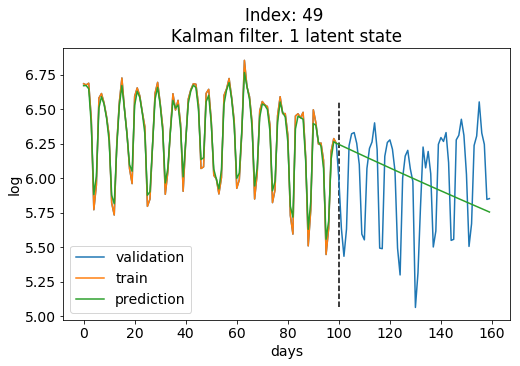

50 finished


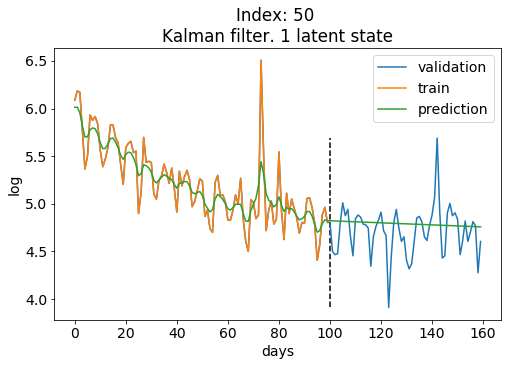

51 finished


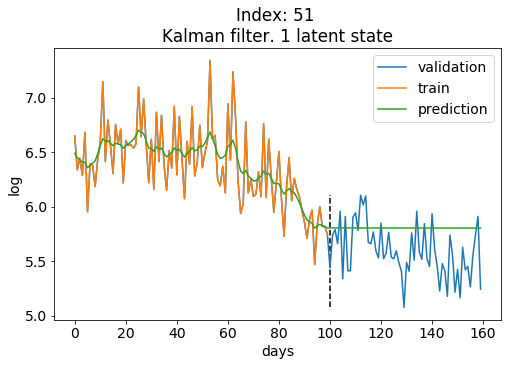

53 finished


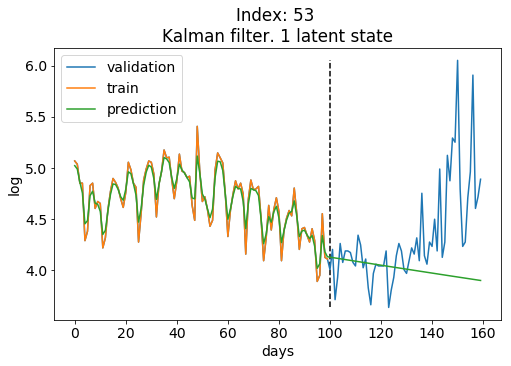

55 finished


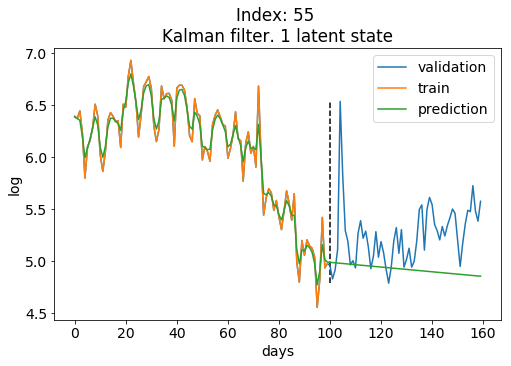

In [130]:
for i in weekly_indices[:6].ravel():
    row_train = log_train_for_val[i]
    preds = KF_for_row(i, only_forecast=False)
    
    plot_KF(row_train, np.log1p(np.array(test.iloc[i])),
            preds, 'Index: %i \nKalman filter. 1 latent state' % i)

46 finished


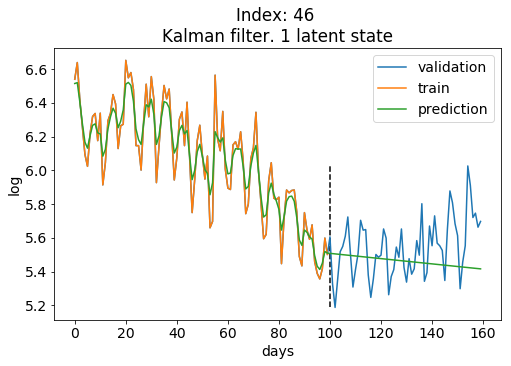

49 finished


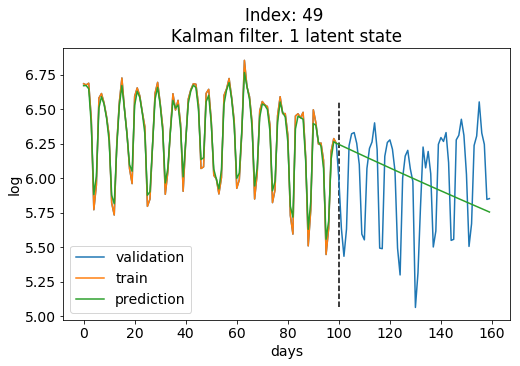

50 finished


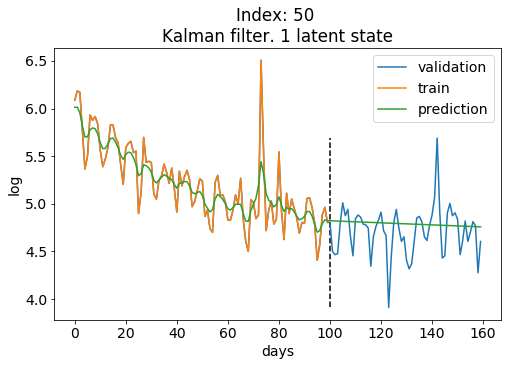

51 finished


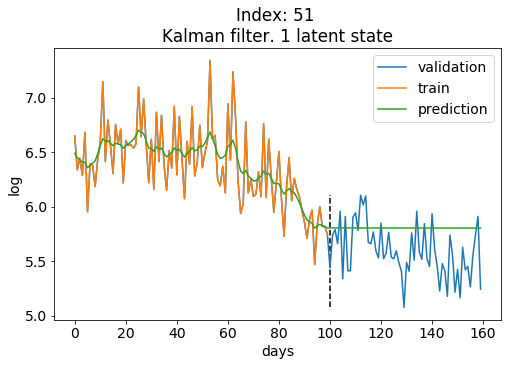

53 finished


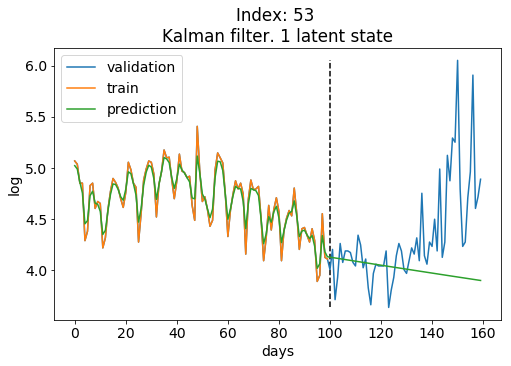

55 finished


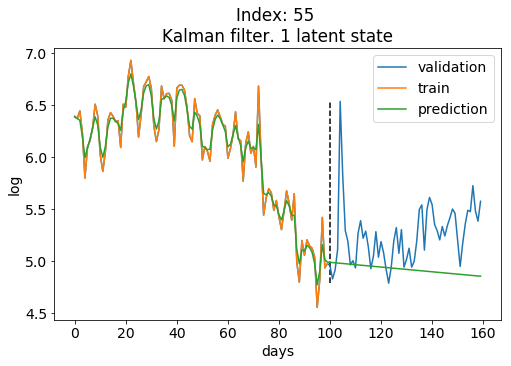

In [134]:
for i in weekly_indices[:6].ravel():
    row_train = log_train_for_val[i]
    preds = KF_for_row(i, only_forecast=False)
    
    plot_KF(row_train, np.log1p(np.array(test.iloc[i])),
            preds, 'Index: %i \nKalman filter. 1 latent state' % i)

In [170]:
from joblib import Parallel, delayed

In [171]:
%%time
predictions_kf = Parallel(n_jobs=20, max_nbytes=None)(
    delayed(KF_for_row)(k, em_vars=[
                  'transition_matrices', 
                  'observation_matrices',
                  'transition_covariance', 
                  'observation_covariance',
#                   'observation_offsets'
    ]) 
    for k in range(2000)
)
print('end')
predictions_kf = np.array(predictions_kf)

19 finished
17 finished
16 finished
18 finished
15 finished
12 finished
14 finished
13 finished
10 finished
9 finished
11 finished
8 finished
5 finished
7 finished
4 finished
6 finished
3 finished
2 finished
0 finished
1 finished
20 finished
21 finished
22 finished
23 finished
24 finished
26 finished
25 finished
28 finished
30 finished
29 finished
27 finished
31 finished
32 finished
33 finished
34 finished
35 finished
36 finished
37 finished
39 finished
38 finished
40 finished
41 finished
43 finished
42 finished
44 finished
45 finished
46 finished
48 finished
47 finished
50 finished
49 finished
51 finished
53 finished
52 finished
55 finished
54 finished
56 finished
57 finished
59 finished
58 finished
60 finished
61 finished
63 finished
62 finished
65 finished
64 finished
66 finished
67 finished
68 finished
69 finished
70 finished
71 finished
72 finished
73 finished
74 finished
75 finished
76 finished
77 finished
78 finished
79 finished
80 finished
81 finished
83 finished
82 finished
85

638 finished
640 finished
643 finished
642 finished
644 finished
641 finished
645 finished
646 finished
648 finished
647 finished
651 finished
652 finished
649 finished
650 finished
653 finished
654 finished
655 finished
656 finished
658 finished
659 finished
657 finished
660 finished
661 finished
662 finished
663 finished
664 finished
665 finished
666 finished
667 finished
668 finished
669 finished
670 finished
671 finished
672 finished
673 finished
674 finished
676 finished
675 finished
677 finished
680 finished
678 finished
679 finished
681 finished
682 finished
683 finished
684 finished
686 finished
685 finished
687 finished
688 finished
689 finished
690 finished
691 finished
692 finished
693 finished
694 finished
695 finished
697 finished
696 finished
698 finished
699 finished
701 finished
702 finished
700 finished
703 finished
705 finished
704 finished
706 finished
707 finished
708 finished
709 finished
710 finished
711 finished
712 finished
713 finished
714 finished
716 finished

1249 finished
1251 finished
1252 finished
1253 finished
1254 finished
1255 finished
1256 finished
1257 finished
1258 finished
1259 finished
1260 finished
1261 finished
1262 finished
1263 finished
1264 finished
1265 finished
1266 finished
1267 finished
1268 finished
1269 finished
1270 finished
1271 finished
1273 finished
1272 finished
1274 finished
1275 finished
1276 finished
1277 finished
1281 finished
1279 finished
1278 finished
1280 finished
1282 finished
1283 finished
1284 finished
1285 finished
1286 finished
1287 finished
1288 finished
1289 finished
1290 finished
1291 finished
1293 finished
1292 finished
1294 finished
1295 finished
1296 finished
1297 finished
1298 finished
1301 finished
1300 finished
1299 finished
1302 finished
1303 finished
1304 finished
1305 finished
1306 finished
1307 finished
1308 finished
1309 finished
1310 finished
1311 finished
1312 finished
1314 finished
1313 finished
1316 finished
1315 finished
1318 finished
1319 finished
1317 finished
1320 finished
1321 f

1835 finished
1837 finished
1839 finished
1838 finished
1840 finished
1841 finished
1842 finished
1843 finished
1844 finished
1846 finished
1850 finished
1847 finished
1845 finished
1849 finished
1848 finished
1851 finished
1852 finished
1853 finished
1854 finished
1855 finished
1856 finished
1858 finished
1857 finished
1861 finished
1862 finished
1859 finished
1863 finished
1860 finished
1864 finished
1865 finished
1866 finished
1867 finished
1868 finished
1870 finished
1871 finished
1869 finished
1872 finished
1873 finished
1874 finished
1875 finished
1876 finished
1877 finished
1878 finished
1880 finished
1879 finished
1881 finished
1882 finished
1883 finished
1884 finished
1886 finished
1885 finished
1887 finished
1888 finished
1889 finished
1890 finished
1891 finished
1892 finished
1893 finished
1894 finished
1896 finished
1897 finished
1895 finished
1898 finished
1899 finished
1900 finished
1901 finished
1902 finished
1904 finished
1903 finished
1905 finished
1906 finished
1907 f

In [174]:
predictions_kf = utils.from_log_and_correction(predictions_kf) 

In [176]:
utils.SaveModel("kalmam_filter",
                predictions_kf, test,
                "555 hours", "no transformation",
                index.values.reshape(-1))

In [178]:
np.nanmean(utils.SMAPE_score(predictions_kf, test))

SMAPE:  47.74657293620517


47.746572936205176

# Adding seasonality

In [9]:
def KF_with_seasonality_for_row(
    i, em_vars=[
                  'transition_matrices', 
                  'observation_matrices',
                  'transition_covariance', 
                  'observation_covariance',
#                   'transition_offsets',
#                   'observation_offsets',
#                   'initial_state_mean',
#                   'initial_state_covariance'
    ], 
    only_forecast=True
):
    
    def predicting(days=60):
        preds = []
        last_z_mean = smoothed_state_means[-1]
        for i in range(60):
            new_z_mean = kf.transition_matrices.dot(last_z_mean)
            preds.append(kf.observation_matrices.dot(new_z_mean))
            last_z_mean = new_z_mean

        preds = np.array(preds).ravel()
        return preds
    
    smoothing_factor = 5.0
    n_seasons = 7
    n_dim_state = n_seasons + 1

    kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=1)

    # --- define state transition matrix A
    state_transition = np.zeros((n_seasons + 1, n_seasons + 1))
    # hidden level
    state_transition[0,0] = 1
    # season cycle
    state_transition[1,1:-1] = [-1.0] * (n_seasons - 1)
    state_transition[2:,1:-1] = np.eye(n_seasons - 1)
    kf.transition_matrices = state_transition


    # --- observation model H
    # observation is hidden level + weekly seasonal compoenent
    kf.observation_matrices = np.array([[1,1] + [0] * (n_seasons - 1)])


    # --- noise models, parametrized by the smoothing factor
    level_noise = 0.2 / smoothing_factor
    observation_noise = 0.2
    season_noise = 1e-3

    kf.transition_covariance = np.diag([level_noise, season_noise] + [0]*(n_seasons-1))**2
    kf.observation_covariance = observation_noise**2

    if em_vars:
        # Use EM algorithm to estimate the parameters
        kf.em(log_train_for_val[i][-100:], n_iter=10, em_vars=em_vars)
    
    # Smoothing
    smoothed_state_means, _ = kf.smooth(log_train_for_val[i])

    # Sampling
#     sampled_states, sampled_observations = kf.sample(60, initial_state=smoothed_state_means[-1], random_state=np.random.RandomState(0))
    preds = predicting()
    print(i, "finished")
    
    if only_forecast:
        return preds
    else:
        smoothed_observations = np.sum(np.multiply(smoothed_state_means, kf.observation_matrices.ravel()), axis=1)
        return np.array(np.concatenate((smoothed_observations.ravel(), preds)))
    

def plot_KF_with_seasonality(row_train, row_val, preds, title, lags=100):
    plt.plot(np.concatenate((row_train[-lags:], row_val)), label='validation')
    plt.vlines(lags, row_val.min(), row_val.max(), linestyles='--')
    plt.plot(row_train[-lags:], label='train')
    plt.plot(preds[-(lags + 60):], label='prediction')
    plt.xlabel('days')
    plt.ylabel('log')
    plt.legend()
    plt.title(title)
    plt.show()

In [12]:
i = 43
preds = KF_with_seasonality_for_row(
    i, only_forecast=False,
    em_vars=[
                  'transition_matrices', 
                  'observation_matrices',
                  'transition_covariance', 
                  'observation_covariance',
#                   'transition_offsets',
#                   'observation_offsets',
#                   'initial_state_mean',
#       'initial_state_covariance'
    ])

43 finished


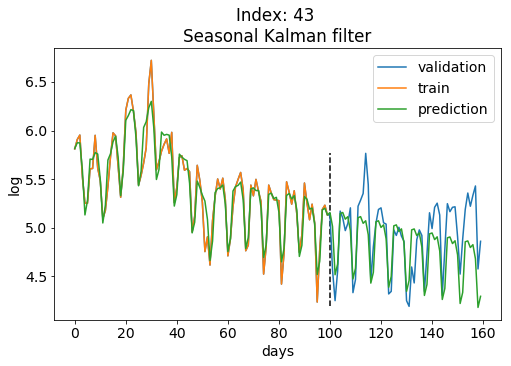

In [14]:
row_train = log_train_for_val[i]
plot_KF_with_seasonality(row_train, np.log1p(np.array(test.iloc[i])),
        preds, 'Index: %i \nSeasonal Kalman filter' % i)

In [16]:
from joblib import Parallel, delayed

In [17]:
%%time
predictions_seas = Parallel(n_jobs=20, max_nbytes=None)(
    delayed(KF_with_seasonality_for_row)(k, em_vars=[
#                   'transition_matrices', 
#                   'observation_matrices',
#                   'transition_covariance', 
#                   'observation_covariance',
#                   'transition_offsets',
#                   'observation_offsets',
#                   'initial_state_mean',
#                   'initial_state_covariance'
    ])
    for k in range(2000)
)
print('end')
predictions_seas = np.array(predictions_seas)

1 finished
0 finished
11 finished
6 finished
16 finished
2 finished
4 finished
14 finished
10 finished
3 finished
9 finished
15 finished
13 finished
19 finished
8 finished
17 finished
12 finished
18 finished
7 finished
5 finished
22 finished
25 finished
27 finished
20 finished
23 finished
21 finished
30 finished
36 finished
28 finished
24 finished
33 finished
29 finished
35 finished
26 finished
31 finished
38 finished
32 finished
37 finished
34 finished
39 finished
40 finished
42 finished
43 finished
41 finished
45 finished
48 finished
46 finished
50 finished
44 finished
53 finished
49 finished
52 finished
47 finished
57 finished
54 finished
59 finished
58 finished
51 finished
55 finished
56 finished
62 finished
61 finished
60 finished
63 finished
64 finished
65 finished
66 finished
67 finished
69 finished
68 finished
73 finished
74 finished
70 finished
72 finished
75 finished
76 finished
71 finished
78 finished
77 finished
79 finished
80 finished
81 finished
84 finished
82 finished
87

639 finished
640 finished
641 finished
642 finished
643 finished
646 finished
645 finished
644 finished
647 finished
649 finished
650 finished
648 finished
653 finished
654 finished
652 finished
651 finished
655 finished
656 finished
657 finished
658 finished
659 finished
662 finished
661 finished
660 finished
663 finished
664 finished
665 finished
666 finished
668 finished
667 finished
669 finished
670 finished
671 finished
673 finished
672 finished
674 finished
675 finished
676 finished
677 finished
678 finished
679 finished
681 finished
680 finished
683 finished
684 finished
682 finished
685 finished
686 finished
688 finished
687 finished
689 finished
692 finished
690 finished
691 finished
693 finished
694 finished
695 finished
696 finished
697 finished
698 finished
699 finished
700 finished
701 finished
703 finished
702 finished
705 finished
707 finished
706 finished
708 finished
704 finished
712 finished
710 finished
711 finished
713 finished
709 finished
715 finished
714 finished

1250 finished
1251 finished
1252 finished
1254 finished
1257 finished
1253 finished
1256 finished
1255 finished
1258 finished
1259 finished
1260 finished
1261 finished
1262 finished
1263 finished
1264 finished
1268 finished
1265 finished
1269 finished
1267 finished
1266 finished
1270 finished
1271 finished
1272 finished
1273 finished
1275 finished
1276 finished
1274 finished
1278 finished
1277 finished
1279 finished
1280 finished
1281 finished
1282 finished
1283 finished
1284 finished
1285 finished
1288 finished
1286 finished
1287 finished
1289 finished
1290 finished
1291 finished
1293 finished
1292 finished
1294 finished
1295 finished
1296 finished
1298 finished
1297 finished
1299 finished
1301 finished
1300 finished
1303 finished
1302 finished
1305 finished
1304 finished
1306 finished
1308 finished
1307 finished
1310 finished
1309 finished
1311 finished
1312 finished
1313 finished
1314 finished
1315 finished
1316 finished
1317 finished
1318 finished
1319 finished
1320 finished
1321 f

1836 finished
1837 finished
1838 finished
1839 finished
1840 finished
1841 finished
1842 finished
1843 finished
1846 finished
1844 finished
1845 finished
1848 finished
1849 finished
1847 finished
1850 finished
1851 finished
1852 finished
1853 finished
1855 finished
1854 finished
1856 finished
1857 finished
1858 finished
1859 finished
1860 finished
1861 finished
1862 finished
1863 finished
1865 finished
1864 finished
1866 finished
1868 finished
1867 finished
1869 finished
1870 finished
1872 finished
1871 finished
1873 finished
1874 finished
1876 finished
1875 finished
1878 finished
1877 finished
1879 finished
1880 finished
1881 finished
1882 finished
1883 finished
1886 finished
1885 finished
1884 finished
1887 finished
1889 finished
1888 finished
1890 finished
1891 finished
1893 finished
1892 finished
1894 finished
1895 finished
1896 finished
1897 finished
1898 finished
1899 finished
1900 finished
1901 finished
1903 finished
1902 finished
1904 finished
1905 finished
1906 finished
1908 f

In [18]:
predictions_seas = utils.from_log_and_correction(predictions_seas)

In [23]:
utils.SaveModel("kalmam_filter_with_seasonality_no_learn",
                predictions_seas, test,
                "19 hours", "no transformation",
                index.values.reshape(-1))

In [22]:
total_time(48/60, 20)

19.333333333333332

In [49]:
%%time
predictions_seas_learn_all = Parallel(n_jobs=20, max_nbytes=None)(
    delayed(KF_with_seasonality_for_row)(k, em_vars=[
                  'transition_matrices', 
                  'observation_matrices',
                  'transition_covariance', 
                  'observation_covariance',
#                   'transition_offsets',
#                   'observation_offsets',
#                   'initial_state_mean',
#                   'initial_state_covariance'
    ])
    for k in range(2000)
)
print('end')
predictions_seas_learn_all = np.array(predictions_seas_learn_all)

5 finished
2 finished
11 finished
3 finished
9 finished
15 finished
10 finished
7 finished
8 finished
19 finished
0 finished
12 finished
1 finished
4 finished
14 finished
13 finished
17 finished
18 finished
6 finished
16 finished
22 finished
21 finished
25 finished
23 finished
20 finished
29 finished
31 finished
24 finished
28 finished
30 finished
34 finished
36 finished
26 finished
37 finished
38 finished
27 finished
32 finished
33 finished
35 finished
39 finished
42 finished
43 finished
45 finished
46 finished
40 finished
57 finished
48 finished
56 finished
47 finished
44 finished
54 finished
51 finished
52 finished
50 finished
49 finished
55 finished
53 finished
58 finished
41 finished
59 finished
60 finished
62 finished
71 finished
76 finished
63 finished
65 finished
61 finished
77 finished
64 finished
72 finished
68 finished
66 finished
79 finished
70 finished
75 finished
69 finished
67 finished
73 finished
78 finished
74 finished
81 finished
83 finished
82 finished
80 finished
84

639 finished
641 finished
640 finished
642 finished
644 finished
643 finished
645 finished
646 finished
647 finished
648 finished
649 finished
650 finished
651 finished
652 finished
653 finished
654 finished
655 finished
657 finished
656 finished
658 finished
660 finished
661 finished
659 finished
662 finished
665 finished
663 finished
668 finished
666 finished
667 finished
664 finished
669 finished
670 finished
671 finished
672 finished
675 finished
674 finished
673 finished
678 finished
677 finished
676 finished
680 finished
681 finished
679 finished
682 finished
683 finished
686 finished
684 finished
685 finished
687 finished
688 finished
689 finished
691 finished
690 finished
692 finished
693 finished
694 finished
695 finished
696 finished
698 finished
697 finished
699 finished
700 finished
701 finished
702 finished
703 finished
704 finished
705 finished
706 finished
707 finished
708 finished
709 finished
710 finished
711 finished
713 finished
712 finished
714 finished
715 finished

1250 finished
1251 finished
1252 finished
1255 finished
1254 finished
1256 finished
1253 finished
1259 finished
1258 finished
1257 finished
1260 finished
1261 finished
1262 finished
1265 finished
1263 finished
1264 finished
1266 finished
1267 finished
1268 finished
1269 finished
1270 finished
1271 finished
1272 finished
1273 finished
1274 finished
1275 finished
1277 finished
1276 finished
1278 finished
1279 finished
1280 finished
1281 finished
1282 finished
1283 finished
1290 finished
1291 finished
1285 finished
1288 finished
1292 finished
1286 finished
1289 finished
1287 finished
1284 finished
1293 finished
1296 finished
1295 finished
1294 finished
1297 finished
1300 finished
1298 finished
1299 finished
1301 finished
1303 finished
1302 finished
1304 finished
1305 finished
1306 finished
1308 finished
1307 finished
1309 finished
1311 finished
1310 finished
1313 finished
1314 finished
1315 finished
1312 finished
1316 finished
1317 finished
1318 finished
1319 finished
1321 finished
1320 f

1836 finished
1837 finished
1838 finished
1839 finished
1840 finished
1841 finished
1842 finished
1843 finished
1844 finished
1845 finished
1846 finished
1847 finished
1848 finished
1849 finished
1850 finished
1851 finished
1852 finished
1853 finished
1854 finished
1855 finished
1856 finished
1857 finished
1858 finished
1859 finished
1861 finished
1860 finished
1862 finished
1863 finished
1865 finished
1864 finished
1866 finished
1868 finished
1867 finished
1870 finished
1869 finished
1871 finished
1872 finished
1874 finished
1873 finished
1875 finished
1876 finished
1877 finished
1878 finished
1879 finished
1881 finished
1880 finished
1882 finished
1883 finished
1884 finished
1885 finished
1886 finished
1888 finished
1887 finished
1889 finished
1890 finished
1891 finished
1892 finished
1894 finished
1893 finished
1895 finished
1896 finished
1897 finished
1898 finished
1899 finished
1901 finished
1902 finished
1900 finished
1903 finished
1904 finished
1905 finished
1906 finished
1907 f

In [52]:
total_time(2.5, 20)

60.416666666666664

In [53]:
predictions_seas_learn_all = utils.from_log_and_correction(predictions_seas_learn_all) 

In [55]:
utils.SaveModel("kalmam_filter_with_seasonality_learn_all",
                predictions_seas_learn_all, test,
                "60 hours", "no transformation",
                index.values.reshape(-1))